# Imports

In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

# Random agents

## Pendulum-v1

Average reward: -1193.1334302928688
Scores during testing


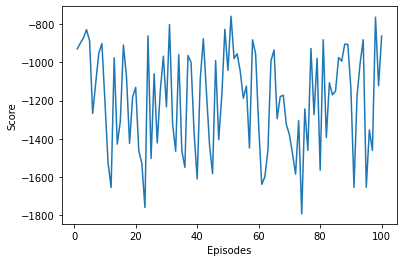

In [2]:
env = gym.make('Pendulum-v1')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## BipedalWalker-v3

Average reward: -99.69894074995928
Scores during testing


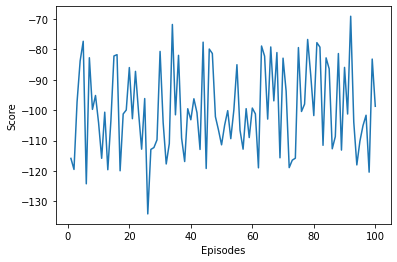

In [3]:
env = gym.make('BipedalWalker-v3')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## BipedalWalkerHardcore-v3

Average reward: -109.19289856340292
Scores during testing


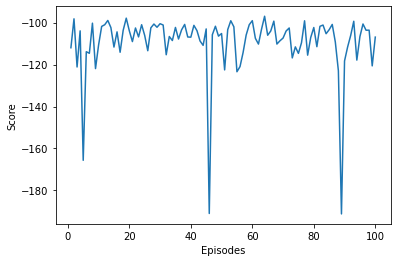

In [4]:
env = gym.make('BipedalWalkerHardcore-v3')

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        action = env.action_space.sample()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state
    
    scores.append(ep_reward)
    
print('Average reward:', np.mean(scores))
print('Scores during testing')
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

# Actor critic methods

In [5]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [6]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## DDPG

### Defining the DDPG agent

In [7]:
class DDPG_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, sigma,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.sigma = sigma
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        # Create actor network, critic network, their target copies, and their optimisers
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        # Create empty lists which will store transitions up to the capacity of the batch size
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        
        # At the start of each episode, reset the environment, score, step, and terminal
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            # If render is set to true, you can watch the agent learn each episode
            if self.render:
                env.render()
            
            # Use the action network to select an action
            # Sample noise from a normal distribution with mean 0 and standard deviation = sigma 
            # Add this noise to the selected action and take this action
            # Observe the outcome and update the episode's running total of the reward
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.sigma, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward
            
            # Store transitions in the memory lists
            # If the batch size is exceeded, replace the oldest transition in the memory list with the new one
            # Note that terminal = 1 if true so if the next state is terminal, 0 will be stored in terminal_memory 
            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward) 
                self.terminal_memory.append(1 - terminal)        
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1 
            
            # When there are more transitions stored than the batch size, randomly sample these transitions
            # Store each element of each sampled transition in these new lists 
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item])
                    terminals.append(self.terminal_memory[item])
                
                # Reformat sample lists 
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                
                # Calculate the actual next state Q values
                # Use this to calculate the actual current state Q values
                # Note that if the next state is terminal, the actual current state Q value will just be the reward
                target_actions = self.target_actor(next_states)
                next_Qtargets = self.target_critic(next_states, target_actions)
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Calculate the expected Q values 
                Qexpected = self.critic(states, actions)
                
                # Perform gradient descent on the critic network
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Perform gradient ascent on the actor network
                actions_predicted = self.actor(states)
                actor_loss = -self.critic(states, actions_predicted)
                actor_loss = torch.mean(actor_loss)
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update all target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))   
            
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    # Test the agent over 100 episodes 
    # Noise is not added to the action selected by the actor network during testing
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            scores.append(ep_reward)
        
        print('Mean score:', np.mean(scores))
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()
    
    # Visualise the agent over 10 episodes
    def visualise(self):
        for i in range(10):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

### Pendulum-v1

*************************************************************
Agent 1
Episode: 10 Score: -1173.811 	 Mean score over last 10 episodes: -1223.439
Episode: 20 Score: -1005.403 	 Mean score over last 10 episodes: -985.079
Episode: 30 Score: -237.384 	 Mean score over last 10 episodes: -587.974
Episode: 40 Score: -121.622 	 Mean score over last 10 episodes: -193.115
Episode: 50 Score: -239.738 	 Mean score over last 10 episodes: -145.143
Episode: 60 Score: -220.258 	 Mean score over last 10 episodes: -131.034
Episode: 70 Score: -126.515 	 Mean score over last 10 episodes: -179.339
Episode: 80 Score: -128.557 	 Mean score over last 10 episodes: -110.388
Episode: 90 Score: -124.855 	 Mean score over last 10 episodes: -409.677
Episode: 100 Score: -120.049 	 Mean score over last 10 episodes: -185.558
Episode: 110 Score: -133.216 	 Mean score over last 10 episodes: -300.861
Episode: 120 Score: -234.974 	 Mean score over last 10 episodes: -149.384
Episode: 130 Score: -251.814 	 Mean score over l

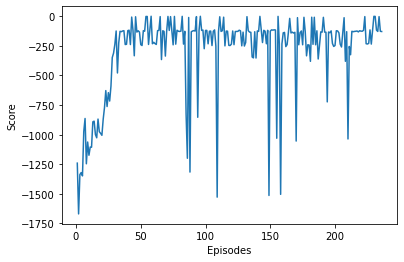

Agent 1 mean score of last 10 episodes during training


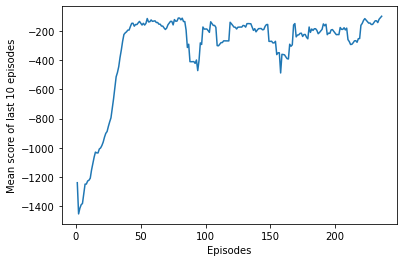

Agent 1 scores during testing
Mean score: -153.12609889846772


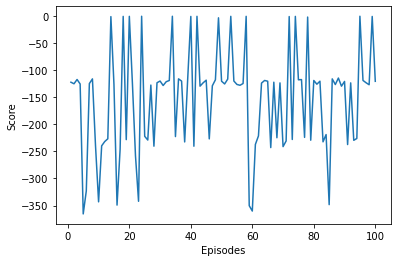

*************************************************************
Agent 2
Episode: 10 Score: -574.623 	 Mean score over last 10 episodes: -1153.870
Episode: 20 Score: -629.117 	 Mean score over last 10 episodes: -664.707
Episode: 30 Score: -250.687 	 Mean score over last 10 episodes: -223.126
Episode: 40 Score: -418.431 	 Mean score over last 10 episodes: -199.010
Episode: 50 Score: -233.720 	 Mean score over last 10 episodes: -253.060
Episode: 60 Score: -239.434 	 Mean score over last 10 episodes: -224.875
Episode: 70 Score: -231.914 	 Mean score over last 10 episodes: -175.744
Episode: 80 Score: -240.897 	 Mean score over last 10 episodes: -248.637
Episode: 90 Score: -327.351 	 Mean score over last 10 episodes: -219.160
Episode: 100 Score: -128.450 	 Mean score over last 10 episodes: -221.480
Episode: 110 Score: -1.341 	 Mean score over last 10 episodes: -188.007
Episode: 120 Score: -3.361 	 Mean score over last 10 episodes: -208.081
Episode: 130 Score: -124.386 	 Mean score over last 10

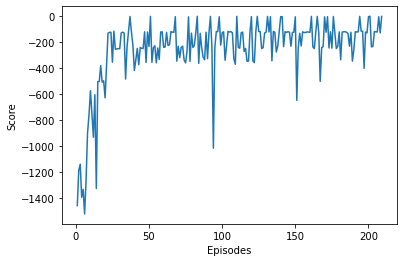

Agent 2 mean score of last 10 episodes during training


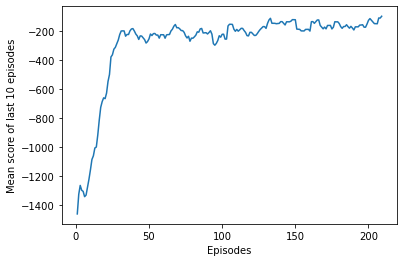

Agent 2 scores during testing
Mean score: -138.22359966658686


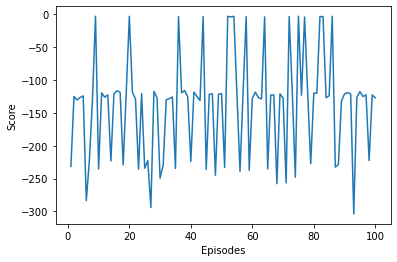

*************************************************************
Agent 3
Episode: 10 Score: -1118.533 	 Mean score over last 10 episodes: -1206.497
Episode: 20 Score: -127.773 	 Mean score over last 10 episodes: -765.656
Episode: 30 Score: -244.105 	 Mean score over last 10 episodes: -233.759
Episode: 40 Score: -339.041 	 Mean score over last 10 episodes: -199.506
Episode: 50 Score: -240.798 	 Mean score over last 10 episodes: -193.571
Episode: 60 Score: -231.653 	 Mean score over last 10 episodes: -135.120
Episode: 70 Score: -12.781 	 Mean score over last 10 episodes: -174.609
Episode: 80 Score: -0.995 	 Mean score over last 10 episodes: -137.040
Episode: 90 Score: -120.395 	 Mean score over last 10 episodes: -151.549
Episode: 100 Score: -120.449 	 Mean score over last 10 episodes: -388.130
Episode: 110 Score: -226.186 	 Mean score over last 10 episodes: -168.775
Episode: 120 Score: -238.322 	 Mean score over last 10 episodes: -171.285
Episode: 130 Score: -220.539 	 Mean score over last 

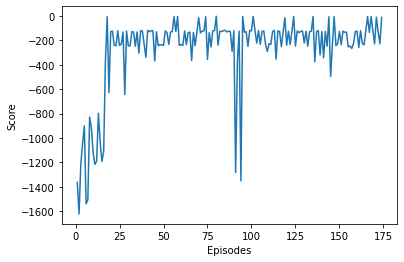

Agent 3 mean score of last 10 episodes during training


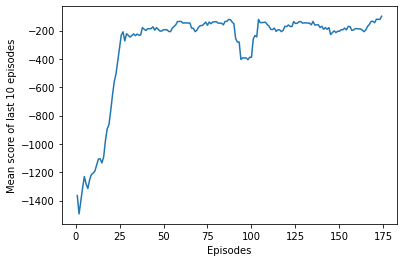

Agent 3 scores during testing
Mean score: -157.62088045349026


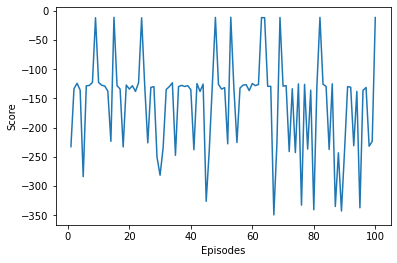

*************************************************************
Agent 4
Episode: 10 Score: -669.087 	 Mean score over last 10 episodes: -1102.470
Episode: 20 Score: -123.136 	 Mean score over last 10 episodes: -393.653
Episode: 30 Score: -126.081 	 Mean score over last 10 episodes: -178.867
Episode: 40 Score: -227.139 	 Mean score over last 10 episodes: -145.897
Episode: 50 Score: -230.458 	 Mean score over last 10 episodes: -179.301
Episode: 60 Score: -127.020 	 Mean score over last 10 episodes: -169.051
Episode: 70 Score: -365.387 	 Mean score over last 10 episodes: -345.647
Episode: 80 Score: -123.913 	 Mean score over last 10 episodes: -189.309
Episode: 90 Score: -251.903 	 Mean score over last 10 episodes: -146.223
Episode: 100 Score: -243.297 	 Mean score over last 10 episodes: -102.179
Episode: 110 Score: -129.863 	 Mean score over last 10 episodes: -148.215
Episode: 120 Score: -119.313 	 Mean score over last 10 episodes: -155.269
Episode: 130 Score: -772.752 	 Mean score over las

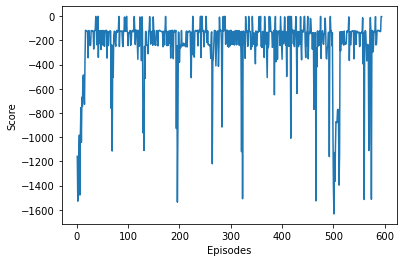

Agent 4 mean score of last 10 episodes during training


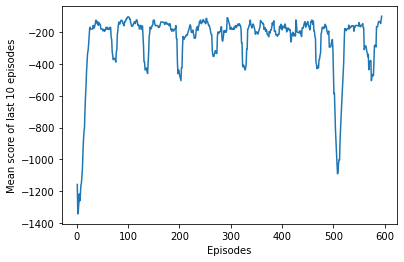

Agent 4 scores during testing
Mean score: -174.38694627752193


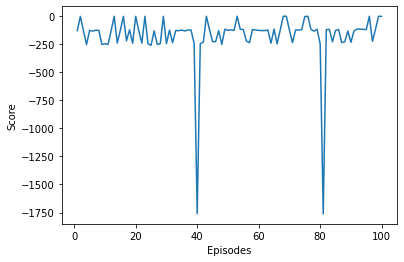

*************************************************************
Agent 5
Episode: 10 Score: -1582.140 	 Mean score over last 10 episodes: -1532.404
Episode: 20 Score: -1152.879 	 Mean score over last 10 episodes: -1052.603
Episode: 30 Score: -513.338 	 Mean score over last 10 episodes: -735.459
Episode: 40 Score: -762.975 	 Mean score over last 10 episodes: -659.518
Episode: 50 Score: -268.055 	 Mean score over last 10 episodes: -307.499
Episode: 60 Score: -146.763 	 Mean score over last 10 episodes: -237.637
Episode: 70 Score: -266.421 	 Mean score over last 10 episodes: -243.651
Episode: 80 Score: -121.795 	 Mean score over last 10 episodes: -275.924
Episode: 90 Score: -117.337 	 Mean score over last 10 episodes: -328.902
Episode: 100 Score: -126.407 	 Mean score over last 10 episodes: -180.754
Episode: 110 Score: -232.784 	 Mean score over last 10 episodes: -186.128
Episode: 120 Score: -244.578 	 Mean score over last 10 episodes: -334.308
Episode: 130 Score: -123.635 	 Mean score over 

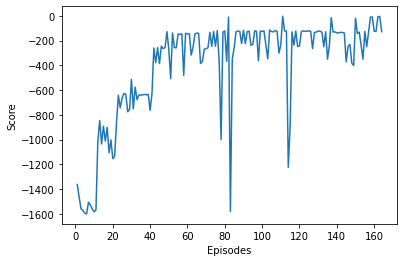

Agent 5 mean score of last 10 episodes during training


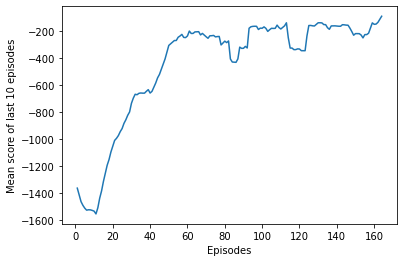

Agent 5 scores during testing
Mean score: -659.373994636681


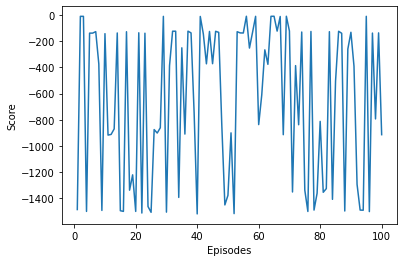

In [8]:
environment = 'Pendulum-v1' # Choose environment
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2 # Scale to the size of that environment's action space
    solved = -100 # No formal score to declare solved. Decided that solving requires a mean score of -100 over 10 episodes
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 # Solving requires a mean score of 300 over 100 episodes

previous = 10 # As solving requires the mean score over 10 episodes 
print_every = 10 # Print every 10 episodes
agents = 5 

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))
    
    # Chosen hyperparameters chosen when creating our agent
    pendulum_DDPG = DDPG_Agent(scaling = scaling, render = False, buffer_size = 10000, batch_size = 64, gamma = 0.99, tau = 0.05, sigma = 0.2,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.001, critic_lr = 0.01)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1
    
    # Keep training while the environment is unsolved or the minimum number of episodes is yet to be completed
    # But stop if the the the number of episodes is more than 3000
    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

        ep_reward = pendulum_DDPG.train()
        
        # Save the episode reward and the mean of the last 10 episodes
        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 
        
        # Print the score and mean of the last 10 episodes every 10 episodes
        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1
    
    # Print the mean agent score, the number of episodes ran, and the final mean of the last 100 episodes 
    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')
    
    # Plot the agent's score for each episode during training
    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()
    
    # Plot the agent's mean of the last 100 episodes for each episode during training
    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    # Plot the agent's score for each episode during testing
    print('Agent {} scores during testing'.format(i))
    pendulum_DDPG.test()

In [9]:
# Visualise the most recent trained agent
environment = 'Pendulum-v1'
env = gym.make(environment)
pendulum_DDPG.visualise()

Episode reward: -143.47343077261004
Episode reward: -122.37145652889622
Episode reward: -260.27669682481826
Episode reward: -142.84462788374915
Episode reward: -137.84109419267924
Episode reward: -129.4355112368663
Episode reward: -254.26889927291217
Episode reward: -137.0221559121037
Episode reward: -127.30586019644058
Episode reward: -900.9686409422183


### BipedalWalker-v3

*************************************************************
Agent 1
Episode: 100 Score: -102.070 	 Mean score over last 100 episodes: -111.151
Episode: 200 Score: -131.360 	 Mean score over last 100 episodes: -122.184
Episode: 300 Score: -139.809 	 Mean score over last 100 episodes: -143.150
Episode: 400 Score: -174.107 	 Mean score over last 100 episodes: -128.711
Episode: 500 Score: -28.226 	 Mean score over last 100 episodes: -103.473
Episode: 600 Score: 13.409 	 Mean score over last 100 episodes: -83.533
Episode: 700 Score: -95.938 	 Mean score over last 100 episodes: -65.440
Episode: 800 Score: -50.941 	 Mean score over last 100 episodes: -59.284
Episode: 900 Score: -18.492 	 Mean score over last 100 episodes: -46.684
Episode: 1000 Score: 94.440 	 Mean score over last 100 episodes: -20.604
Episode: 1100 Score: -101.068 	 Mean score over last 100 episodes: 42.710
Episode: 1200 Score: 269.697 	 Mean score over last 100 episodes: 87.787
Episode: 1300 Score: 162.509 	 Mean score ove

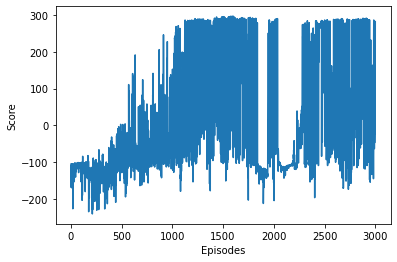

Agent 1 mean score of last 100 episodes during training


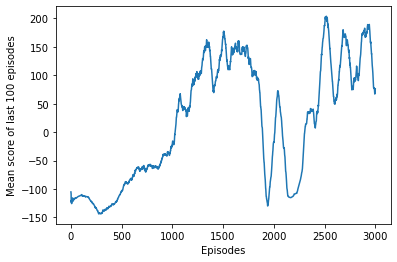

Agent 1 scores during testing
Mean score: 89.99546435523455


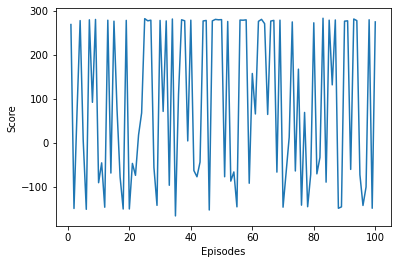

*************************************************************
Agent 2
Episode: 100 Score: -126.216 	 Mean score over last 100 episodes: -137.287
Episode: 200 Score: -149.149 	 Mean score over last 100 episodes: -131.075
Episode: 300 Score: -114.791 	 Mean score over last 100 episodes: -133.174
Episode: 400 Score: -109.881 	 Mean score over last 100 episodes: -120.193
Episode: 500 Score: -14.207 	 Mean score over last 100 episodes: -118.662
Episode: 600 Score: 55.276 	 Mean score over last 100 episodes: -57.539
Episode: 700 Score: -42.909 	 Mean score over last 100 episodes: 23.042
Episode: 800 Score: 232.751 	 Mean score over last 100 episodes: 37.057
Episode: 900 Score: 224.140 	 Mean score over last 100 episodes: 28.611
Episode: 1000 Score: 62.778 	 Mean score over last 100 episodes: 104.334
Episode: 1100 Score: -77.734 	 Mean score over last 100 episodes: 58.600
Episode: 1200 Score: -79.542 	 Mean score over last 100 episodes: 23.156
Episode: 1300 Score: -87.717 	 Mean score over la

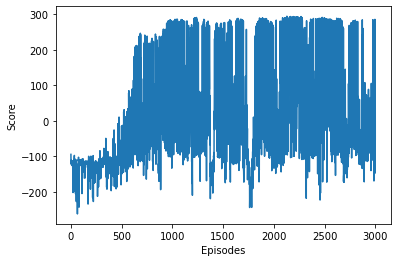

Agent 2 mean score of last 100 episodes during training


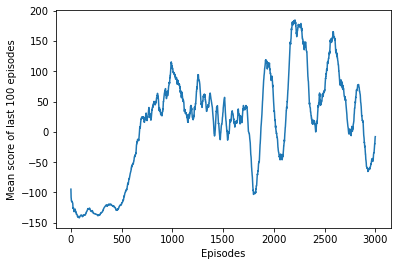

Agent 2 scores during testing
Mean score: 28.294067362535106


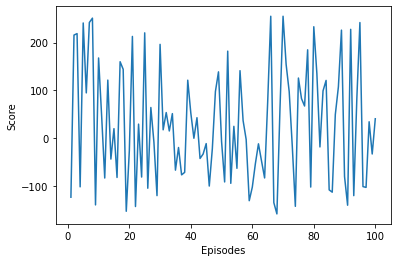

*************************************************************
Agent 3
Episode: 100 Score: -121.842 	 Mean score over last 100 episodes: -114.886
Episode: 200 Score: -154.796 	 Mean score over last 100 episodes: -128.465
Episode: 300 Score: -97.851 	 Mean score over last 100 episodes: -126.665
Episode: 400 Score: 117.012 	 Mean score over last 100 episodes: -71.377
Episode: 500 Score: -116.790 	 Mean score over last 100 episodes: -92.975
Episode: 600 Score: -115.651 	 Mean score over last 100 episodes: -73.622
Episode: 700 Score: 158.738 	 Mean score over last 100 episodes: -61.016
Episode: 800 Score: 73.460 	 Mean score over last 100 episodes: -57.838
Episode: 900 Score: 257.501 	 Mean score over last 100 episodes: 77.330
Episode: 1000 Score: 4.613 	 Mean score over last 100 episodes: 165.889
Episode: 1100 Score: 276.341 	 Mean score over last 100 episodes: 134.812
Episode: 1200 Score: 271.203 	 Mean score over last 100 episodes: 62.319
Episode: 1300 Score: 278.089 	 Mean score over la

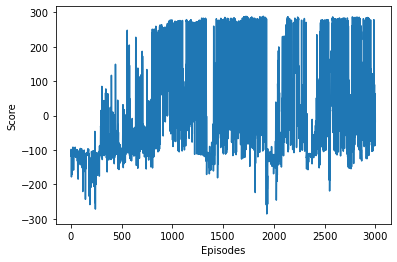

Agent 3 mean score of last 100 episodes during training


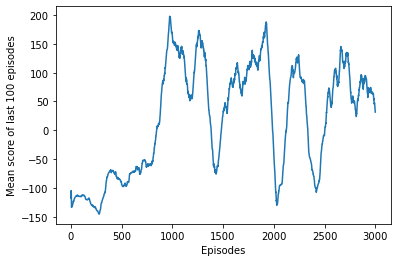

Agent 3 scores during testing
Mean score: 133.4314549109265


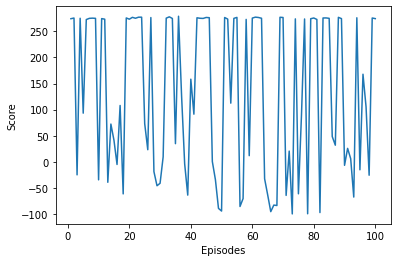

*************************************************************
Agent 4
Episode: 100 Score: -107.704 	 Mean score over last 100 episodes: -117.616
Episode: 200 Score: -145.194 	 Mean score over last 100 episodes: -127.788
Episode: 300 Score: -99.330 	 Mean score over last 100 episodes: -121.346
Episode: 400 Score: -126.737 	 Mean score over last 100 episodes: -126.440
Episode: 500 Score: -147.150 	 Mean score over last 100 episodes: -130.633
Episode: 600 Score: -201.851 	 Mean score over last 100 episodes: -118.441
Episode: 700 Score: 149.594 	 Mean score over last 100 episodes: -86.787
Episode: 800 Score: -37.990 	 Mean score over last 100 episodes: -22.236
Episode: 900 Score: 199.856 	 Mean score over last 100 episodes: -36.987
Episode: 1000 Score: -128.685 	 Mean score over last 100 episodes: 102.971
Episode: 1100 Score: -17.625 	 Mean score over last 100 episodes: 108.588
Episode: 1200 Score: 97.687 	 Mean score over last 100 episodes: 100.885
Episode: 1300 Score: 39.247 	 Mean score

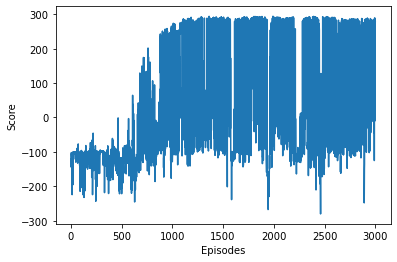

Agent 4 mean score of last 100 episodes during training


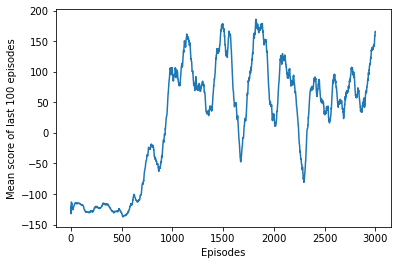

Agent 4 scores during testing
Mean score: 131.16810975269814


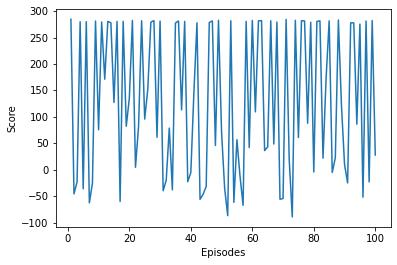

*************************************************************
Agent 5
Episode: 100 Score: -105.284 	 Mean score over last 100 episodes: -112.163
Episode: 200 Score: -123.552 	 Mean score over last 100 episodes: -114.025
Episode: 300 Score: -154.024 	 Mean score over last 100 episodes: -113.488
Episode: 400 Score: -126.329 	 Mean score over last 100 episodes: -113.041
Episode: 500 Score: -4.831 	 Mean score over last 100 episodes: -78.096
Episode: 600 Score: -104.732 	 Mean score over last 100 episodes: -44.674
Episode: 700 Score: 0.175 	 Mean score over last 100 episodes: -3.951
Episode: 800 Score: -98.463 	 Mean score over last 100 episodes: 54.543
Episode: 900 Score: -101.120 	 Mean score over last 100 episodes: 39.970
Episode: 1000 Score: -17.942 	 Mean score over last 100 episodes: 48.748
Episode: 1100 Score: 267.466 	 Mean score over last 100 episodes: 30.472
Episode: 1200 Score: 278.197 	 Mean score over last 100 episodes: 20.704
Episode: 1300 Score: -87.529 	 Mean score over las

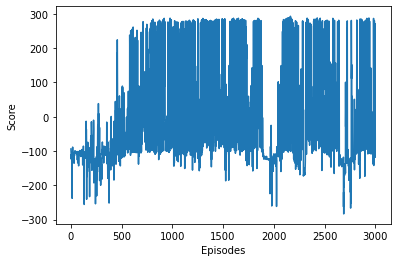

Agent 5 mean score of last 100 episodes during training


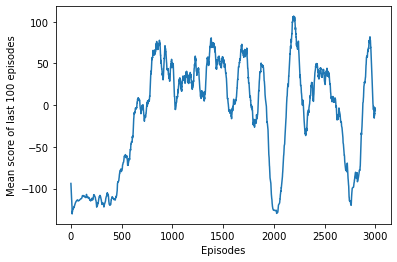

Agent 5 scores during testing
Mean score: 76.35153151712902


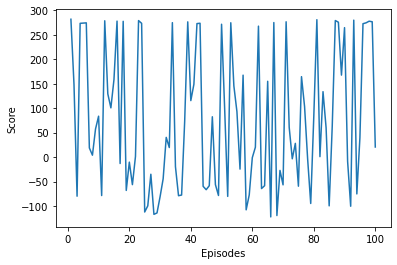

In [10]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 5

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    walker_DDPG = DDPG_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

        ep_reward = walker_DDPG.train()

        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    walker_DDPG.test()

In [14]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)

walker_DDPG.visualise()

2022-05-05 06:51:02.096 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe409d230d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:02.097 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe41e7097e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:02.100 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41e704080>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:02.104 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41d64f8a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 267.5354757034151


2022-05-05 06:51:09.309 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41d653860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:09.313 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe41d60aa20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:09.320 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41d608be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:09.322 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41d609960>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 169.7475814364122


2022-05-05 06:51:25.272 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41786acb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:25.273 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe417832980>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:25.275 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe417832c30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:25.276 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe417832ee0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -72.69338372017444


2022-05-05 06:51:29.522 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f7181a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:29.525 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe41f7386e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:29.534 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f724160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:29.539 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f721220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 45.30482087805308


2022-05-05 06:51:39.607 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f7f5020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:39.607 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe41f78f5a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:39.609 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f77cfa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:39.611 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f75cae0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -28.6561201907936


2022-05-05 06:51:46.077 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40eb0a080>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:46.081 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe40e9ef9e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:46.089 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40e9efc90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:46.093 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe408638560>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 97.92640204864594


2022-05-05 06:51:59.484 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41f745b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:59.488 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe40e9dca60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:59.494 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40e9d2400>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:51:59.499 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40eb3de40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 264.67440348267024


2022-05-05 06:52:15.689 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe4197f2e60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:15.692 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe408636d20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:15.699 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe408635860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:15.704 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40860f260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 32.644096995278176


2022-05-05 06:52:25.516 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40a3c7ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:25.520 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe40cb7b9a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:25.529 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40cb45360>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:25.535 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40cb33e60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 5.897878413821857


2022-05-05 06:52:33.452 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe420ca4ee0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:33.453 python[36507:1255827] Warning: Expected min height of view: (<NSButton: 0x7fe40862d200>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:33.458 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe40862a340>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 06:52:33.460 python[36507:1255827] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe41c2140c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -4.877579810636135
